# **Visual Analytics Final Project**
## **A Visual Music Recommender System Powered by Spotify Data**
---
### Members:
- Marina Castellano Blanco NIA 242409
- Júlia Othats-Dalès Gibert NIA 254435


## **1. Libraries**

This section imports all necessary **Python libraries** for data manipulation, visualization, etc. We also set a default visual style for plots.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
sns.set(style="whitegrid")

## **2. Loading and Merging**

This section handles the **loading of three main datasets** (Track/Artist data, Artist Metadata, and Audio Features) from CSV files. It includes initial **data cleaning** steps, such as:
1.  Converting track durations to **seconds**.
2.  **Concatenating** fragmented datasets.
3.  Cleaning **artist names** to isolate the main artist for accurate **merging** with artist metadata (e.g., country of origin).
4.  Standardizing column names across datasets.

### 2.1. Dataset Spotify Tracks and Artists

In [3]:
data1 = pd.read_csv('data/track_artists/spotify_data1.csv')
data2 = pd.read_csv('data/track_artists/spotify_data2.csv')

# Convertir duración a segundos
if 'track_duration_min' in data1.columns:
    data1['track_duration_sec'] = (data1['track_duration_min'] * 60).round().astype(int)
    data1.drop(columns=['track_duration_min'], inplace=True)

if 'track_duration_ms' in data2.columns:
    data2['track_duration_sec'] = (data2['track_duration_ms'] / 1000).round().astype(int)
    data2.drop(columns=['track_duration_ms'], inplace=True)

# Concatenar datasets
df_spotify = pd.concat([data1, data2], axis=0).reset_index(drop=True)

df_spotify.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_sec
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77.0,2812821.0,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,93
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64.0,2363438.0,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,184
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48.0,193302.0,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,153
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77.0,2813710.0,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,101
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48.0,8682.0,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,143


### 2.2 Limpieza de nombres de artistas y merge con metadata

In [4]:
artist_meta = pd.read_csv("data/helper/artist_country.csv")
artist_meta['artist_name'] = artist_meta['artist'].str.strip().str.lower()
df_spotify['main_artist_clean'] = df_spotify['artist_name'].str.extract(
    r'^(.*?)(?:\s*\(?\s*(?:ft\.|feat\.|featuring)\s+.*)?$', flags=re.IGNORECASE
)[0].str.strip().str.lower()

df_spotify = df_spotify.merge(
    artist_meta[['artist_name', 'country']],
    left_on='main_artist_clean',
    right_on='artist_name',
    how='left'
)

df_spotify = df_spotify.drop(columns=['main_artist_clean', 'artist_name_y'])
df_spotify = df_spotify.rename(columns={'artist_name_x': 'artist_name'})

# Mostrar las primeras filas del dataframe de metadatos de artistas
artist_meta.head()

,Unnamed: 0,index,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3,artist_name
0,0,0,Drake,male,33,person,CA,NaN,NaN,Toronto,NaN,NaN,NaN,drake
1,1,1,Post Malone,male,25,person,US,NaN,NaN,Syracuse,NaN,NaN,NaN,post malone
2,2,2,Ed Sheeran,male,29,person,GB,NaN,NaN,Halifax,NaN,NaN,NaN,ed sheeran
3,3,3,J Balvin,male,35,person,CO,NaN,NaN,Medellín,NaN,NaN,NaN,j balvin
4,4,4,Bad Bunny,male,26,person,PR,NaN,NaN,San Juan,NaN,NaN,NaN,bad bunny


### 2.3 Dataset Tracks' Audio Features

In [5]:
df_audiofeatures1 = pd.read_csv("data/audio_features/spotify_audio_features1.csv", encoding='latin1')
df_audiofeatures1 = df_audiofeatures1.drop(df_audiofeatures1.columns[0], axis=1) 
df_audiofeatures2 = pd.read_csv("data/audio_features/spotify_audio_features2.csv", encoding='latin1')
df_audiofeatures2 = df_audiofeatures2.drop(df_audiofeatures2.columns[0], axis=1) 

# rename columns to match df_audiofeatures1
df_audiofeatures1 = df_audiofeatures1.rename(columns={
    'Title': 'title',
    'Artist': 'artist',
    'Top Genre': 'top genre',
    'Year': 'year',
    'Beats Per Minute (BPM)': 'bpm',
    'Energy': 'nrgy',
    'Danceability': 'dnce',
    'Loudness (dB)': 'dB',
    'Liveness': 'live',
    'Valence': 'val',
    'Length (Duration)': 'dur',
    'Acousticness': 'acous',
    'Speechiness': 'spch',
    'Popularity': 'pop'
})

df_audiofeatures = pd.concat([df_audiofeatures1, df_audiofeatures2], axis=0).reset_index(drop=True)
df_audiofeatures.head()

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


## **3. Limpieza de datos**

This section focuses on **cleaning** the merged datasets to ensure quality for analysis and modeling. Key steps include:
1.  Handling **missing values** (`NaN`) by removing rows where critical information (e.g., artist name, track name) is absent.
2.  Removing **duplicate** songs based on track and artist name.
3.  Processing **date** columns to extract the track's release year and month.
4.  Final checks for missing values and duplicates in the **Audio Features** dataset.
The cleaned dataframes are saved for later use.

### 3.1. Tracks / Artists Dataset

In [6]:
print("Spotify dataset info:")
df_spotify.info()

# La mayoría son duplicados

Spotify dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17504 entries, 0 to 17503
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            17504 non-null  object 
 1   track_name          17502 non-null  object 
 2   track_number        17504 non-null  int64  
 3   track_popularity    17504 non-null  int64  
 4   explicit            17504 non-null  bool   
 5   artist_name         17497 non-null  object 
 6   artist_popularity   17500 non-null  float64
 7   artist_followers    17500 non-null  float64
 8   artist_genres       14122 non-null  object 
 9   album_id            17504 non-null  object 
 10  album_name          17502 non-null  object 
 11  album_release_date  17504 non-null  object 
 12  album_total_tracks  17504 non-null  int64  
 13  album_type          17504 non-null  object 
 14  track_duration_sec  17504 non-null  int64  
 15  country             9717 non-nu

In [7]:
print(f"Tamaño inicial del dataset: {df_spotify.shape}")

print("\nValores faltantes por columna:")
print(df_spotify.isna().sum())
df_spotify = df_spotify.dropna(subset=['artist_name', 'artist_popularity', 'track_name', 'artist_followers', 'album_name'])
print(f"\nEliminando filas con valores faltantes en columnas clave. Nuevo tamaño del dataset: {df_spotify.shape}")

Tamaño inicial del dataset: (17504, 16)

Valores faltantes por columna:
track_id                 0
track_name               2
track_number             0
track_popularity         0
explicit                 0
artist_name              7
artist_popularity        4
artist_followers         4
artist_genres         3382
album_id                 0
album_name               2
album_release_date       0
album_total_tracks       0
album_type               0
track_duration_sec       0
country               7787
dtype: int64

Eliminando filas con valores faltantes en columnas clave. Nuevo tamaño del dataset: (17495, 16)


In [8]:
print(f"\nEliminando {df_spotify.duplicated(subset=['track_name','artist_name']).sum()} duplicados de canciones...")
df_spotify = df_spotify.drop_duplicates(subset=['track_name','artist_name'], keep='last')
print(f"\nNuevo tamaño del dataset después de eliminar duplicados: {df_spotify.shape}")


Eliminando 9455 duplicados de canciones...

Nuevo tamaño del dataset después de eliminar duplicados: (8040, 16)


In [9]:
# Procesar fechas de lanzamiento
df_spotify['album_release_date'] = pd.to_datetime(df_spotify['album_release_date'], errors='coerce')
df_spotify['release_year'] = df_spotify['album_release_date'].dt.year
df_spotify['release_month'] = df_spotify['album_release_date'].dt.month

In [10]:
# Save final spotify dataframe
df_spotify.to_csv('data/spotify_tracks_artists.csv', index=False)
df_spotify.to_excel('data/tableau/spotify_tracks_artists.xlsx', index=False)

### 3.2. Audio Features Dataset

In [11]:
df_audiofeatures.head()

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


In [12]:
df_audiofeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2597 non-null   object
 1   artist     2597 non-null   object
 2   top genre  2597 non-null   object
 3   year       2597 non-null   int64 
 4   bpm        2597 non-null   int64 
 5   nrgy       2597 non-null   int64 
 6   dnce       2597 non-null   int64 
 7   dB         2597 non-null   int64 
 8   live       2597 non-null   int64 
 9   val        2597 non-null   int64 
 10  dur        2597 non-null   object
 11  acous      2597 non-null   int64 
 12  spch       2597 non-null   int64 
 13  pop        2597 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 284.2+ KB


In [13]:
df_audiofeatures.describe()

,year,bpm,nrgy,dnce,dB,live,val,acous,spch,pop
count,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000
mean,1998.008086,119.827878,62.192915,55.825183,-8.212168,18.724682,50.062765,25.484020,5.775895,61.150558
std,16.857520,27.316104,21.433564,15.638844,3.758918,15.965464,24.358683,27.997266,5.465946,14.687606
min,1956.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1984.000000,100.000000,46.000000,45.000000,-10.000000,9.000000,30.000000,3.000000,3.000000,52.000000
50%,2002.000000,120.000000,65.000000,56.000000,-7.000000,12.000000,49.000000,13.000000,4.000000,64.000000
75%,2013.000000,134.000000,80.000000,67.000000,-6.000000,23.000000,69.000000,43.000000,6.000000,72.000000
max,2019.000000,206.000000,100.000000,97.000000,-2.000000,99.000000,99.000000,99.000000,55.000000,100.000000


In [14]:
print("Number of Duplicates: ", df_audiofeatures.duplicated().sum())
df_audiofeatures = df_audiofeatures.drop_duplicates().reset_index(drop=True)
print("Number of Duplicates after dropping: ", df_audiofeatures.duplicated().sum())

Number of Duplicates:  0
Number of Duplicates after dropping:  0


In [15]:
print("Number of Genres: ", len(df_audiofeatures["top genre"].unique()))

print("Number of songs in each genre:")

df_audiofeatures["top genre"].value_counts()

Number of Genres:  167
Number of songs in each genre:


top genre
album rock            413
dance pop             410
adult standards       123
pop                   107
dutch pop              88
                     ... 
australian hip hop      1
canadian latin          1
french indie pop        1
moroccan pop            1
alternative r&b         1
Name: count, Length: 167, dtype: int64

**Raw Dataset Summary**

There are:
- 2597 entries (non-null) / 2688 after removing duplicates
- 15 total variables columns
- 167 genre entries

Data Types:
- 4 categorical columns 
- 10 numerical columns

In [16]:
# convert lenth to integer data type (s)
print(f"Length (Duration) data type before: {df_audiofeatures['dur'].dtype}")

df_audiofeatures.replace(',','', regex=True, inplace=True)
df_audiofeatures['dur']= df_audiofeatures['dur'].apply(pd.to_numeric,errors='coerce')

print(f"Length (Duration) data type after: {df_audiofeatures['dur'].dtype}")

Length (Duration) data type before: object
Length (Duration) data type after: int64


In [17]:
# consolidate genre column
genre_keywords = {
    'hip hop': 'hip hop',
    'rock': 'rock',
    'pop': 'pop',
    'metal': 'metal',
    'country': 'country',
    "indie": "indie",
    "jazz": "jazz",
    "alternative": "alternative",
    "singer-songwriter": "singer-songwriter",
}

def generalize_genre(genre):
    for keyword, consolidated_genre in genre_keywords.items():
        if keyword in genre.lower():  # Case-insensitive match
            return consolidated_genre
    return genre  # Return original if no match found


# Create a copy of the genre column and apply the transformation
new_genre = df_audiofeatures['top genre'].copy().apply(generalize_genre)

print(
    f"New Total of Genres from {len(df_audiofeatures['top genre'].unique())} to --> {len(new_genre.unique())}")

New Total of Genres from 167 to --> 78


In [18]:
new_genre.value_counts()

top genre
pop                873
rock               858
adult standards    123
metal               93
indie               80
                  ... 
motown               1
gangster rap         1
diva house           1
hollywood            1
canadian latin       1
Name: count, Length: 78, dtype: int64

- Above shows consolidated genre column into single/more generalistic genres into rock, pop etc.
- There is also an expected increase in values due to the consolidating the genres.

In [19]:
df_audiofeatures['genre'] = new_genre
df_audiofeatures.drop(columns=['top genre'], inplace=True)
df_audiofeatures.head()

,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,genre
0,Sunrise,Norah Jones,2004,157,30,53,-14,11,68,201,94,3,71,adult standards
1,Black Night,Deep Purple,2000,135,79,50,-11,17,81,207,17,7,39,rock
2,Clint Eastwood,Gorillaz,2001,168,69,66,-9,7,52,341,2,17,69,hip hop
3,The Pretender,Foo Fighters,2007,173,96,43,-4,3,37,269,0,4,76,metal
4,Waitin' On A Sunny Day,Bruce Springsteen,2002,106,82,58,-5,10,87,256,1,3,59,rock


In [20]:
# Save final audio features dataframe
df_audiofeatures.to_csv('data/spotify_audio_features.csv', index=False)
df_audiofeatures.to_excel('data/tableau/spotify_audio_features.xlsx', index=False)

## **4. Exploratory Data Analysis**

This section performs a deep **Exploratory Data Analysis (EDA)** using descriptive statistics and visualizations to uncover patterns and relationships in the data. We analyze:
1.  **Basic statistics** and **distributions** of key metrics like track and artist popularity.
2.  The relationship between artist metrics (popularity and followers) and average track popularity.
3.  The **most frequent genres** in the dataset.
4.  **Temporal trends**, such as the number of tracks released per year and the evolution of average track duration.
5.  Exploration of the **audio features** (e.g., energy, danceability, valence) including their distributions, **correlations**, and how they relate to the target variable: **Popularity**.

### 4.1. Basic Statistics

In [21]:
print("Descripción numérica Spotify:")
display(df_spotify.describe())
print("Descripción categórica Spotify:")
display(df_spotify.describe(include="O"))

Descripción numérica Spotify:


,track_number,track_popularity,artist_popularity,artist_followers,album_release_date,album_total_tracks,track_duration_sec,release_year,release_month
count,8040.000000,8040.000000,8040.000000,8.040000e+03,7855,8040.000000,8040.000000,7855.000000,7855.000000
mean,5.808955,51.679229,68.594776,2.203544e+07,2015-11-11 13:55:57.097390336,13.808458,208.842537,2015.371483,6.438320
min,1.000000,0.000000,0.000000,0.000000e+00,1952-09-12 00:00:00,1.000000,4.000000,1952.000000,1.000000
25%,1.000000,38.000000,58.000000,3.443340e+05,2012-09-28 00:00:00,6.000000,171.000000,2012.000000,3.000000
50%,4.000000,57.000000,73.000000,5.042529e+06,2018-05-11 00:00:00,13.000000,205.500000,2018.000000,7.000000
75%,9.000000,70.000000,83.000000,2.576170e+07,2022-09-03 12:00:00,17.000000,239.000000,2022.000000,10.000000
max,102.000000,100.000000,100.000000,1.455421e+08,2025-10-31 00:00:00,181.000000,811.000000,2025.000000,12.000000
std,6.074880,23.600617,19.802093,3.628336e+07,NaN,12.077841,64.973066,9.727494,3.506113


Descripción categórica Spotify:


,track_id,track_name,artist_name,artist_genres,album_id,album_name,album_type,country
count,8040,8040,8040,7994,8040,8040,8040,4238
unique,7928,7579,2548,675,4879,4659,3,34
top,6wf7Yu7cxBSPrRlWeSeK0Q,Ghost,Taylor Swift,[],3FFGbUutKWN1c4f0CJR4Uh,Nevermind (Super Deluxe Edition),album,US
freq,2,7,246,3940,70,70,5427,2613


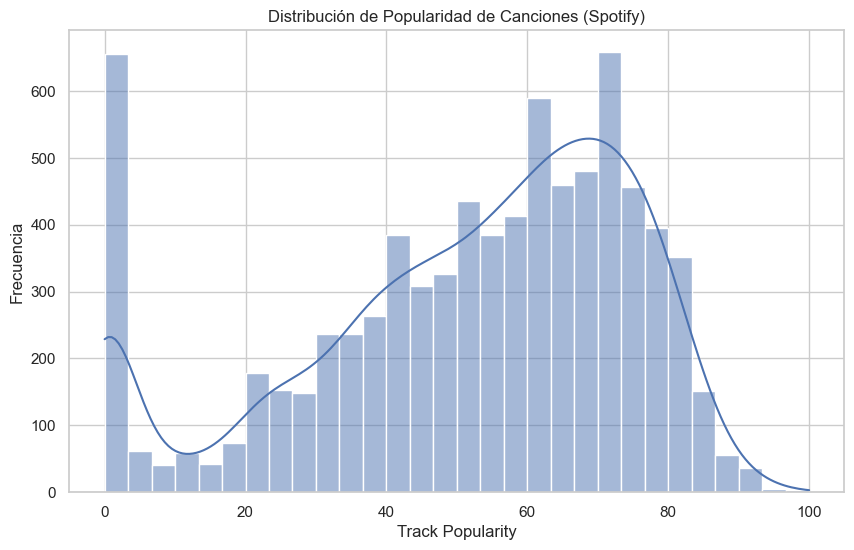

In [22]:
# Distribución de popularidad de tracks
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['track_popularity'], bins=30, kde=True)
plt.title('Distribución de Popularidad de Canciones (Spotify)')
plt.xlabel('Track Popularity')
plt.ylabel('Frecuencia')
plt.show()

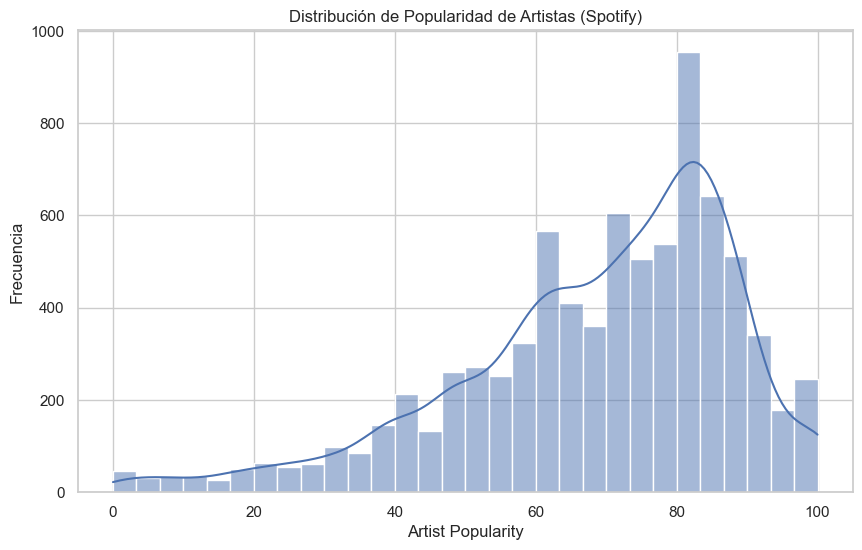

In [23]:
# Distribución de popularidad de artistas
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['artist_popularity'], bins=30, kde=True)
plt.title('Distribución de Popularidad de Artistas (Spotify)')
plt.xlabel('Artist Popularity')
plt.ylabel('Frecuencia')
plt.show()

In [24]:
# Top 10 tracks y artistas
top10_tracks = df_spotify.sort_values(by='track_popularity', ascending=False).head(10)
top10_artists = df_spotify.drop_duplicates(subset='artist_name').sort_values(by='artist_popularity', ascending=False).head(10)

print("Top 10 Tracks (Spotify):")
display(top10_tracks[['track_name','artist_name','album_name','track_popularity']])
print("\nTop 10 Artists (Spotify):")
display(top10_artists[['artist_name','artist_popularity','artist_followers']])


Top 10 Tracks (Spotify):


,track_name,artist_name,album_name,track_popularity
15804,The Fate of Ophelia,Taylor Swift,The Life of a Showgirl,100
13066,Golden,HUNTR/X,KPop Demon Hunters (Soundtrack from the Netfli...,99
14195,Opalite,Taylor Swift,The Life of a Showgirl,97
12325,Man I Need,Olivia Dean,Man I Need,95
15157,Elizabeth Taylor,Taylor Swift,The Life of a Showgirl,95
10060,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,94
17383,Father Figure,Taylor Swift,The Life of a Showgirl,94
11811,Soda Pop,Saja Boys,KPop Demon Hunters (Soundtrack from the Netfli...,94
14749,Wood,Taylor Swift,The Life of a Showgirl,93
10534,How It’s Done,HUNTR/X,KPop Demon Hunters (Soundtrack from the Netfli...,93



Top 10 Artists (Spotify):


,artist_name,artist_popularity,artist_followers
1496,Taylor Swift,100.0,145396321.0
8800,Drake,95.0,103039388.0
8697,Bad Bunny,95.0,102500980.0
5617,The Weeknd,94.0,112995439.0
8726,Justin Bieber,91.0,85008100.0
9088,Sabrina Carpenter,91.0,26516295.0
5546,Rihanna,90.0,68997177.0
8686,Ariana Grande,90.0,107374593.0
1705,Billie Eilish,90.0,118692183.0
9233,Kanye West,89.0,31038851.0


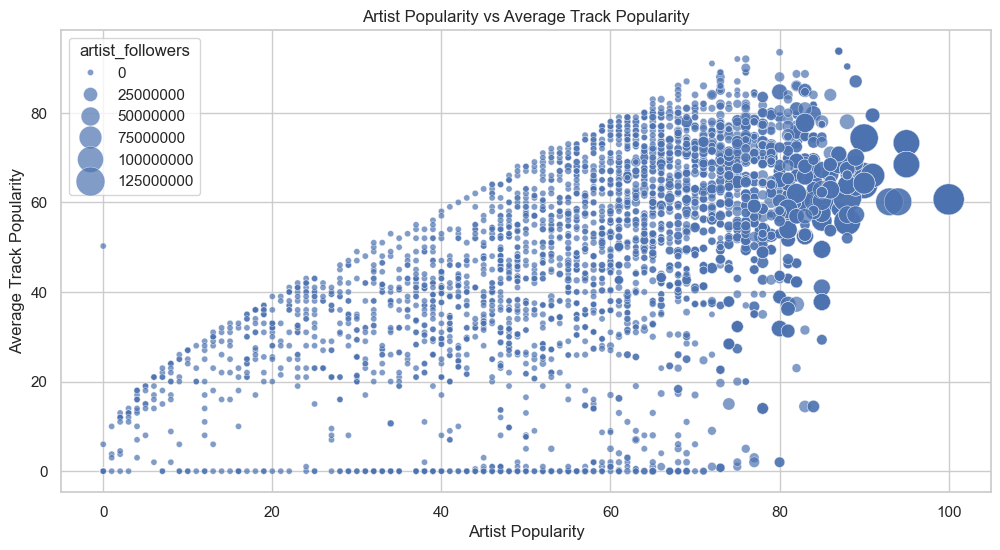

In [25]:
# Scatter: Artist Popularity vs Average Track Popularity
artist_avg_track_pop = df_spotify.groupby('artist_name')['track_popularity'].mean().reset_index().rename(columns={'track_popularity':'avg_track_popularity'})
artist_info = df_spotify[['artist_name','artist_popularity','artist_followers']].drop_duplicates()
artist_pop = artist_avg_track_pop.merge(artist_info, on='artist_name', how='left')

plt.figure(figsize=(12,6))
sns.scatterplot(data=artist_pop, x='artist_popularity', y='avg_track_popularity', size='artist_followers', alpha=0.7, sizes=(20,500))
plt.title('Artist Popularity vs Average Track Popularity')
plt.xlabel('Artist Popularity')
plt.ylabel('Average Track Popularity')
plt.grid(True)
plt.show()

### 4.2 Géneros más frecuentes

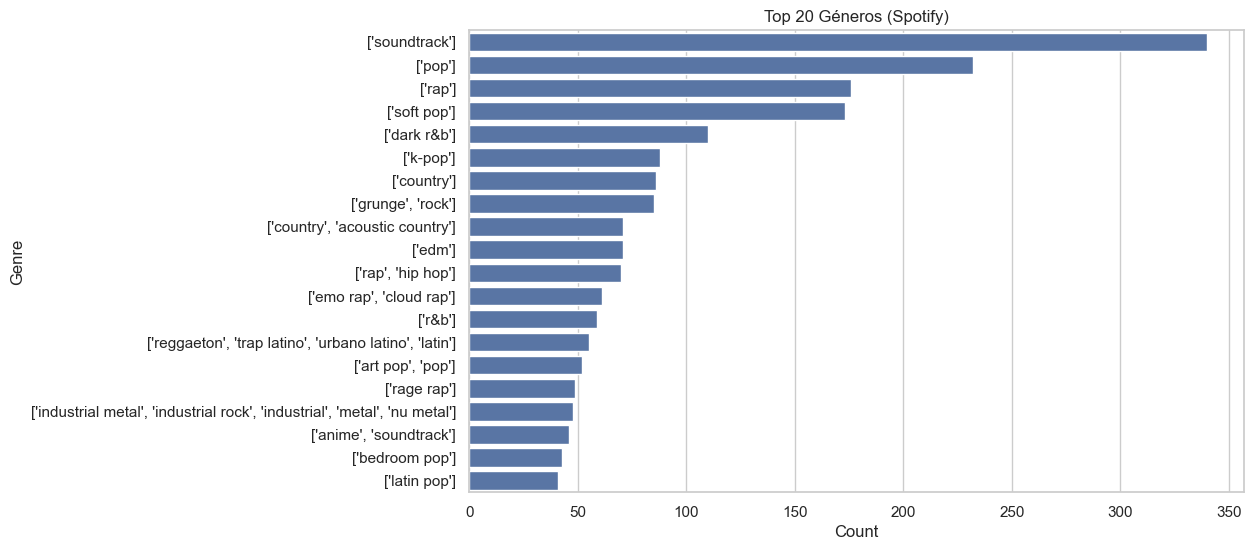

In [26]:
all_genres = df_spotify['artist_genres'].explode().dropna()
all_genres = all_genres[all_genres != '[]']
top_genres = Counter(all_genres).most_common(20)

plt.figure(figsize=(10,6))
sns.barplot(x=[g[1] for g in top_genres], y=[g[0] for g in top_genres])
plt.title('Top 20 Géneros (Spotify)')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


### 4.3. Evolución temporal

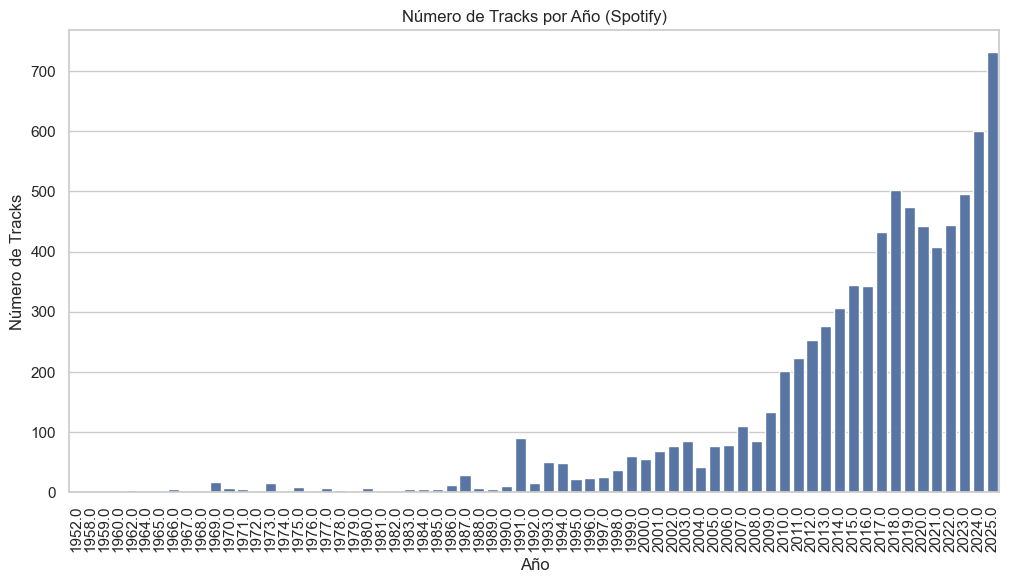

In [27]:
# Número de tracks por año
tracks_per_year = df_spotify.groupby('release_year')['track_id'].count().reset_index().rename(columns={'track_id':'num_tracks'})
plt.figure(figsize=(12,6))
sns.barplot(data=tracks_per_year, x='release_year', y='num_tracks')
plt.title('Número de Tracks por Año (Spotify)')
plt.xlabel('Año')
plt.ylabel('Número de Tracks')
plt.xticks(rotation=90)
plt.show()

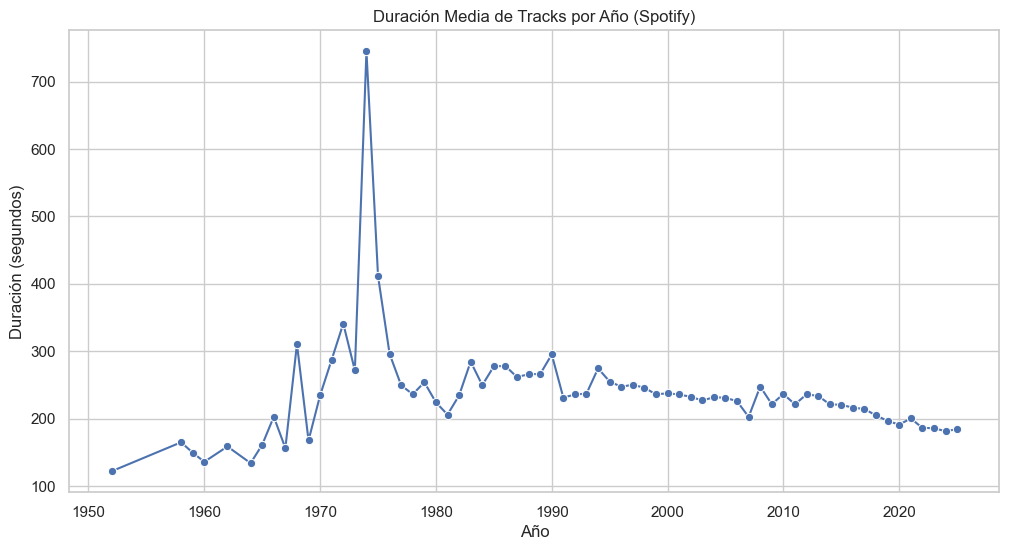

In [28]:
# Duración media de canción por año
avg_duration_per_year = df_spotify.groupby('release_year')['track_duration_sec'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_duration_per_year, x='release_year', y='track_duration_sec', marker='o')
plt.title('Duración Media de Tracks por Año (Spotify)')
plt.xlabel('Año')
plt.ylabel('Duración (segundos)')
plt.grid(True)
plt.show()

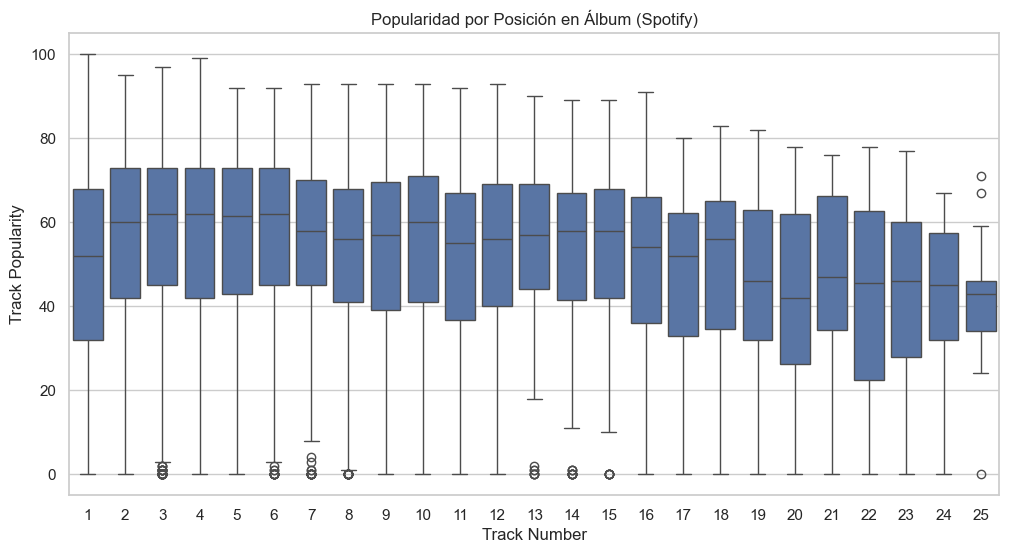

In [29]:
# Track popularity por posición en álbum
df_filtered = df_spotify[df_spotify['track_number'] <= 25]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_filtered, x='track_number', y='track_popularity')
plt.title('Popularidad por Posición en Álbum (Spotify)')
plt.xlabel('Track Number')
plt.ylabel('Track Popularity')
plt.show()

### 4.4. Audio features exploration

In [30]:
def top_10(column):
    top_10_songs = df_audiofeatures.groupby([column]).sum().sort_values('pop', ascending=False).head(10)
    return(top_10_songs[['pop']])

In [31]:
top_10('genre')


,pop
genre,
pop,54774
rock,52138
adult standards,7697
metal,6141
indie,3090
permanent wave,2806
hip hop,2773
british soul,2742
british invasion,2451


In [32]:
top_10('artist')


,pop
artist,
The Beatles,2451
Coldplay,2123
Queen,2085
Ed Sheeran,1808
Michael Jackson,1582
Adele,1575
The Rolling Stones,1496
U2,1476
Bruce Springsteen,1378


In [33]:
pure_popularity = df_audiofeatures.sort_values('pop', ascending=False).head(10)
pure_popularity[['genre', 'year', 'pop']]

,genre,year,pop
793,pop,2019,100
2566,pop,2019,99
787,pop,2019,98
2567,pop,2019,97
2568,pop,2019,96
1641,pop,1994,95
2569,pop,2019,95
786,pop,2019,95
2570,pop,2019,93
2572,pop,2019,92


- The data highlights the accumulation of the most popular genres and artists over time. Notably, the Rock genre has a significant number of entries, making it unsurprising that Rock emerges as the most dominant genre overall. However, Michael Jackson stands out as an outlier, reflecting his exceptional popularity across eras.
- When looking at 'pure' popularity (scored from 0 to 100), a different trend emerges. Pop music and its variations dominate in recent years, suggesting a shift in musical preferences. This shift may be attributed to changes in listening habits influenced by advancements in technology, such as streaming platforms and global accessibility.

In [34]:

# Add a 'year_block' column
df_audiofeatures['year_block'] = pd.cut(df_audiofeatures['year'], bins=4, labels=[1,2,3,4])
df_audiofeatures['year_block'] = df_audiofeatures['year_block'].astype(int)

# Update year_block function
def year_block(block_label):
    block = df_audiofeatures[df_audiofeatures['year_block'] == block_label]
    return block[['genre', 'year', 'pop']]

# Function for creating Top 5 genre value counts for Pie Chart visual:
def genre_count(year_block):
    return year_block['genre'].value_counts().head()

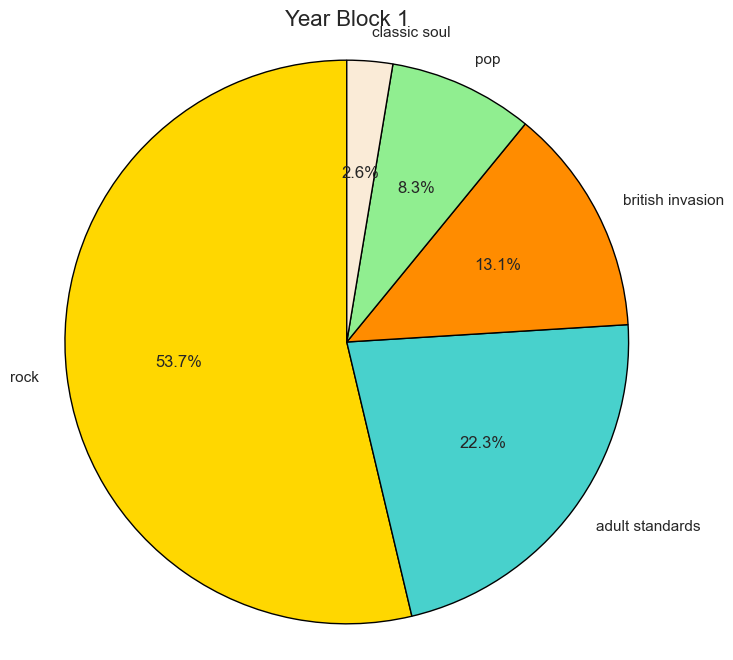

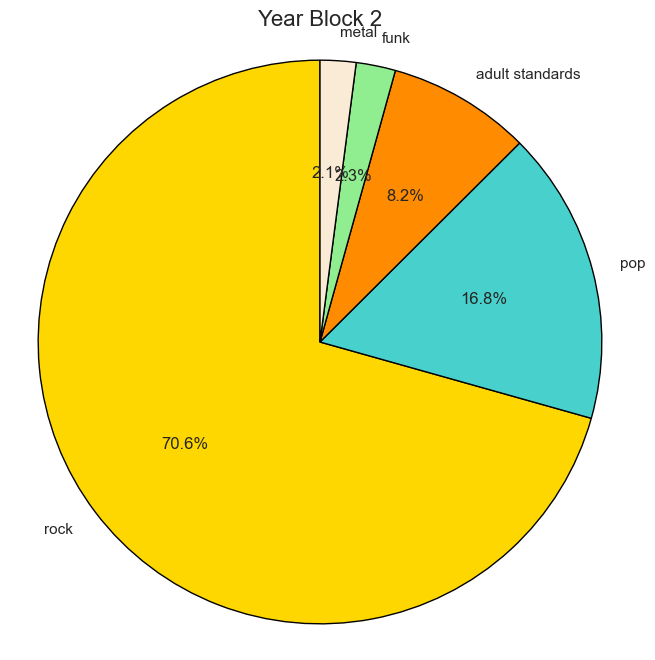

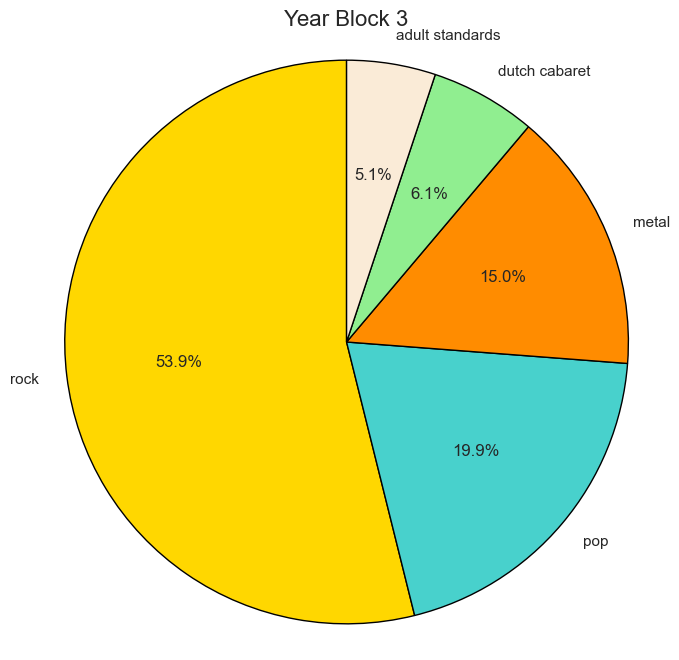

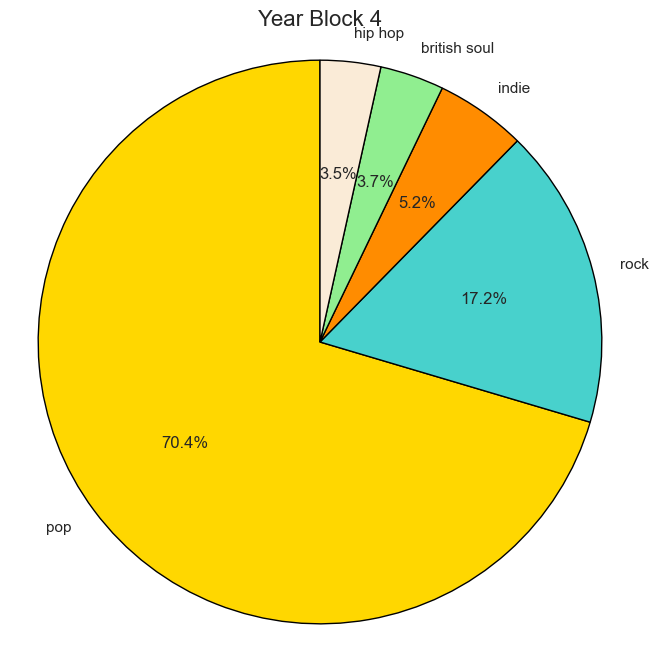

In [35]:
def create_pie_chart(block_num, title):
    """
    Creates a pie chart of top genres for a given year block.
    
    Parameters:
        block_num (int): Year block number (1-4)
        title (str): Chart title
    """
    block_data = year_block(block_num)
    genre_counts = genre_count(block_data)

    if genre_counts.empty:
        print(f"No data for Year Block {block_num}")
        return

    values = genre_counts.values
    labels = genre_counts.index

    # Define colors (repeat if fewer than needed)
    colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', 'AntiqueWhite']
    if len(labels) > len(colors):
        colors = colors * (len(labels) // len(colors) + 1)

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors[:len(labels)],
            startangle=90, wedgeprops={'edgecolor':'black'})
    plt.title(title, fontsize=16)
    plt.axis('equal')  # Make it circular
    plt.show()

# Display pie charts for all year blocks
for block_num in sorted(df_audiofeatures['year_block'].unique()):
    create_pie_chart(block_num, f'Year Block {block_num}')


We can see a shift happening at the half-way mark that switches rock to pop as the most popular genre. 

In [36]:
def top_genres_df(block_num):
    block_data = year_block(block_num)
    top_genres = genre_count(block_data)
    df = top_genres.reset_index()  # index -> genre, values -> count
    df.columns = ['genre', 'count']
    df['year_block'] = block_num
    return df

# Apply to all blocks
dfs = [top_genres_df(i) for i in range(1, 5)]
top_genre_df = pd.concat(dfs, axis=0).reset_index(drop=True)
top_genre_df

,genre,count,year_block
0,rock,123,1
1,adult standards,51,1
2,british invasion,30,1
3,pop,19,1
4,classic soul,6,1
5,rock,344,2
6,pop,82,2
7,adult standards,40,2
8,funk,11,2
9,metal,10,2


To determine the factors influencing a song's popularity, we will analyze numerical audio features and identify correlations between them. This will help us define the most relevant features for building an accurate classification model.

As a first step, we will remove the 'Title' and 'Year' columns since their unique values do not contribute to the predictive power of our model.

In [37]:
df_audiofeatures_no_year = df_audiofeatures.copy()
df_audiofeatures_no_year.drop(columns=['title', 'year'], inplace=True)
df_audiofeatures_no_year.head()

,artist,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,genre,year_block
0,Norah Jones,157,30,53,-14,11,68,201,94,3,71,adult standards,4
1,Deep Purple,135,79,50,-11,17,81,207,17,7,39,rock,3
2,Gorillaz,168,69,66,-9,7,52,341,2,17,69,hip hop,3
3,Foo Fighters,173,96,43,-4,3,37,269,0,4,76,metal,4
4,Bruce Springsteen,106,82,58,-5,10,87,256,1,3,59,rock,3


Music genres with very few entries can negatively impact the efficiency of our model, as they lack sufficient data for meaningful analysis. To address this: Genres with fewer than 20 occurrences in the dataset will be removed, along with their corresponding rows in the original DataFrame.

In [38]:
unique = df_audiofeatures_no_year['genre'].unique()
to_remove = [] 

# genres that have a single instance only will be placed within the to_remove array
for genre in unique:
    count = df_audiofeatures_no_year['genre'].value_counts().get(genre, 0)
    if count < 20:
        to_remove += [genre]
    else:
        print(genre, 'has', count, 'instances')


print(f"Genre Values to be removed from data set = {len(to_remove)}")

adult standards has 123 instances
rock has 858 instances
hip hop has 43 instances
metal has 93 instances
pop has 873 instances
indie has 80 instances
dutch cabaret has 51 instances
permanent wave has 42 instances
british soul has 42 instances
neo mellow has 26 instances
boy band has 21 instances
british invasion has 36 instances
Genre Values to be removed from data set = 66


In [39]:
df_audiofeatures_no_year.set_index(["genre"],drop = False, inplace = True)
for name in to_remove:
    type(name)
    df_audiofeatures_no_year.drop(index = str(name), inplace = True)
df_audiofeatures_no_year = df_audiofeatures_no_year.reset_index(drop=True)
df_audiofeatures_no_year.head()

,artist,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,genre,year_block
0,Norah Jones,157,30,53,-14,11,68,201,94,3,71,adult standards,4
1,Deep Purple,135,79,50,-11,17,81,207,17,7,39,rock,3
2,Gorillaz,168,69,66,-9,7,52,341,2,17,69,hip hop,3
3,Foo Fighters,173,96,43,-4,3,37,269,0,4,76,metal,4
4,Bruce Springsteen,106,82,58,-5,10,87,256,1,3,59,rock,3


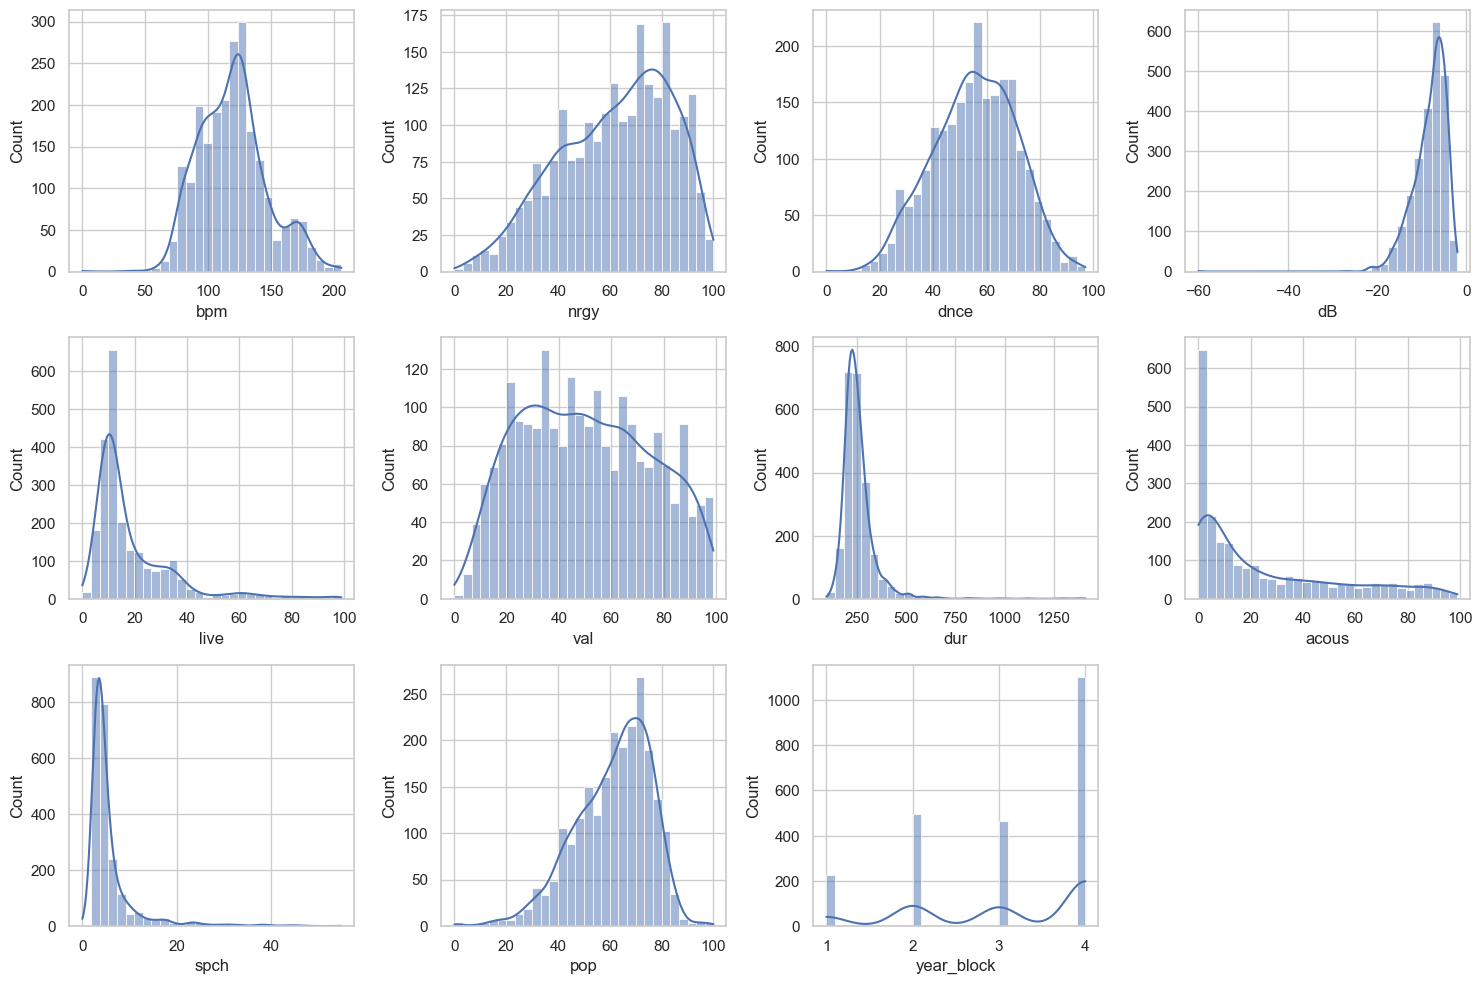

In [40]:
numeric_cols = df_audiofeatures_no_year.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    df_audiofeatures_no_year[col] = pd.to_numeric(df_audiofeatures_no_year[col], errors='coerce')

# Distribuciones
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols,1):
    plt.subplot(3,4,i)
    sns.histplot(df_audiofeatures_no_year[col], kde=True, bins=30)
plt.tight_layout()
plt.show()

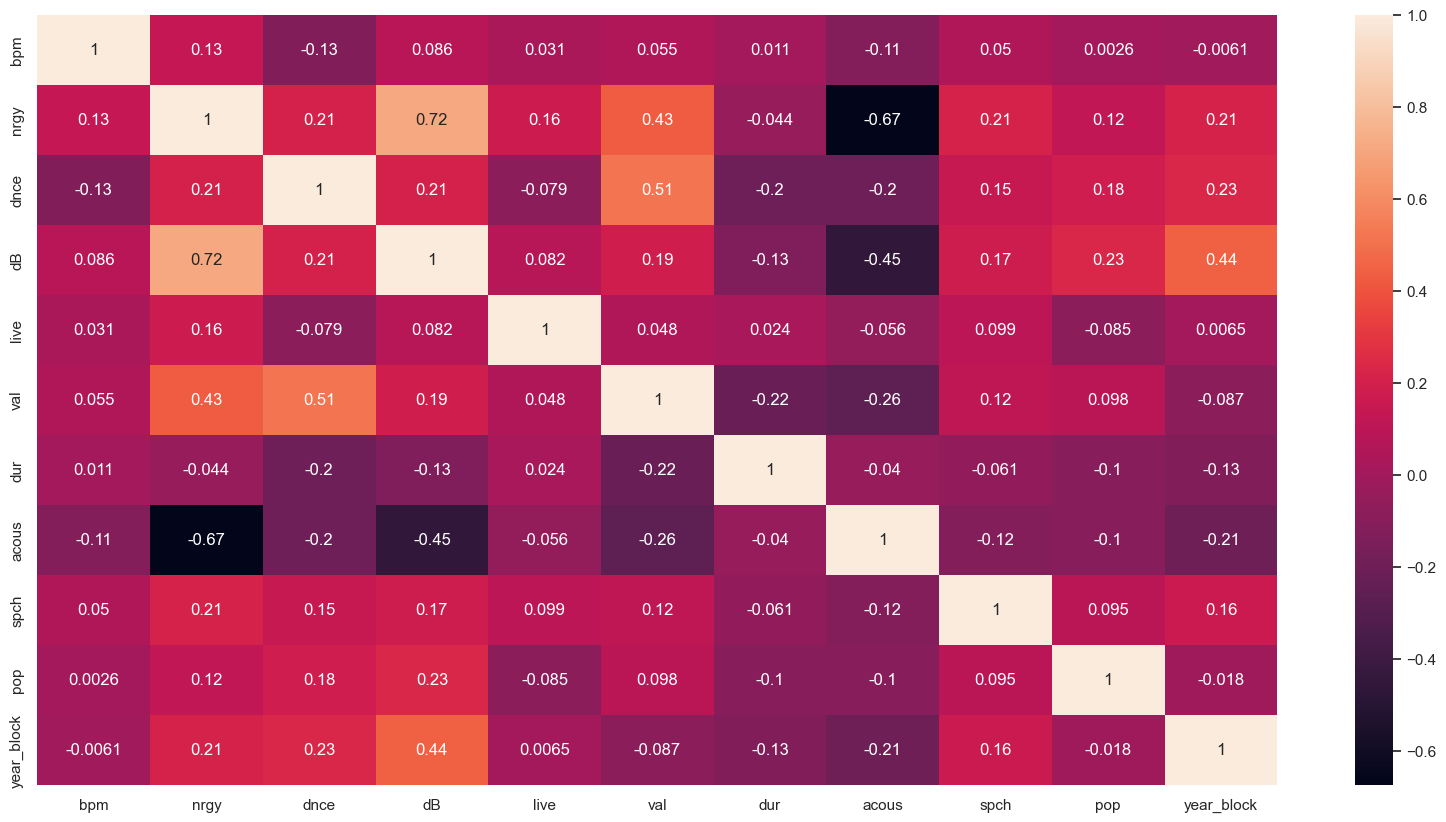

In [41]:
plt.figure(figsize=(20,10))
sns.heatmap(df_audiofeatures_no_year.select_dtypes(include=[np.number]).corr(), annot=True)
plt.show()

From the map above we can see some degree of correlation between the audio features and the song's popularity, although it's not very strong. Loudness (23%), Danceability (18%), ENergy (12%) show the "biggest" correlation with the target. 

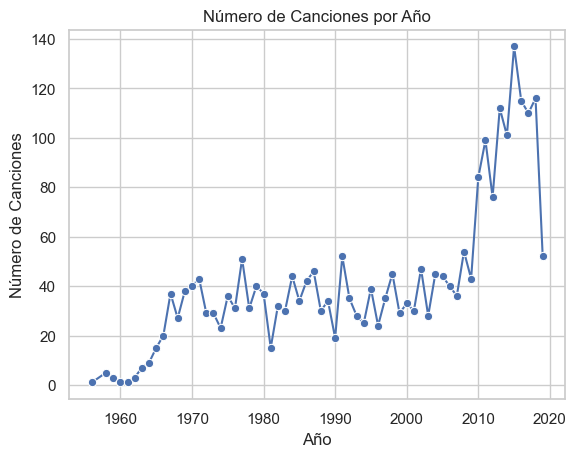

In [42]:
# Número de canciones por año
songs_per_year = df_audiofeatures['year'].value_counts().sort_index()
sns.lineplot(x=songs_per_year.index, y=songs_per_year.values, marker='o')
plt.title('Número de Canciones por Año')
plt.xlabel('Año')
plt.ylabel('Número de Canciones')
plt.show()

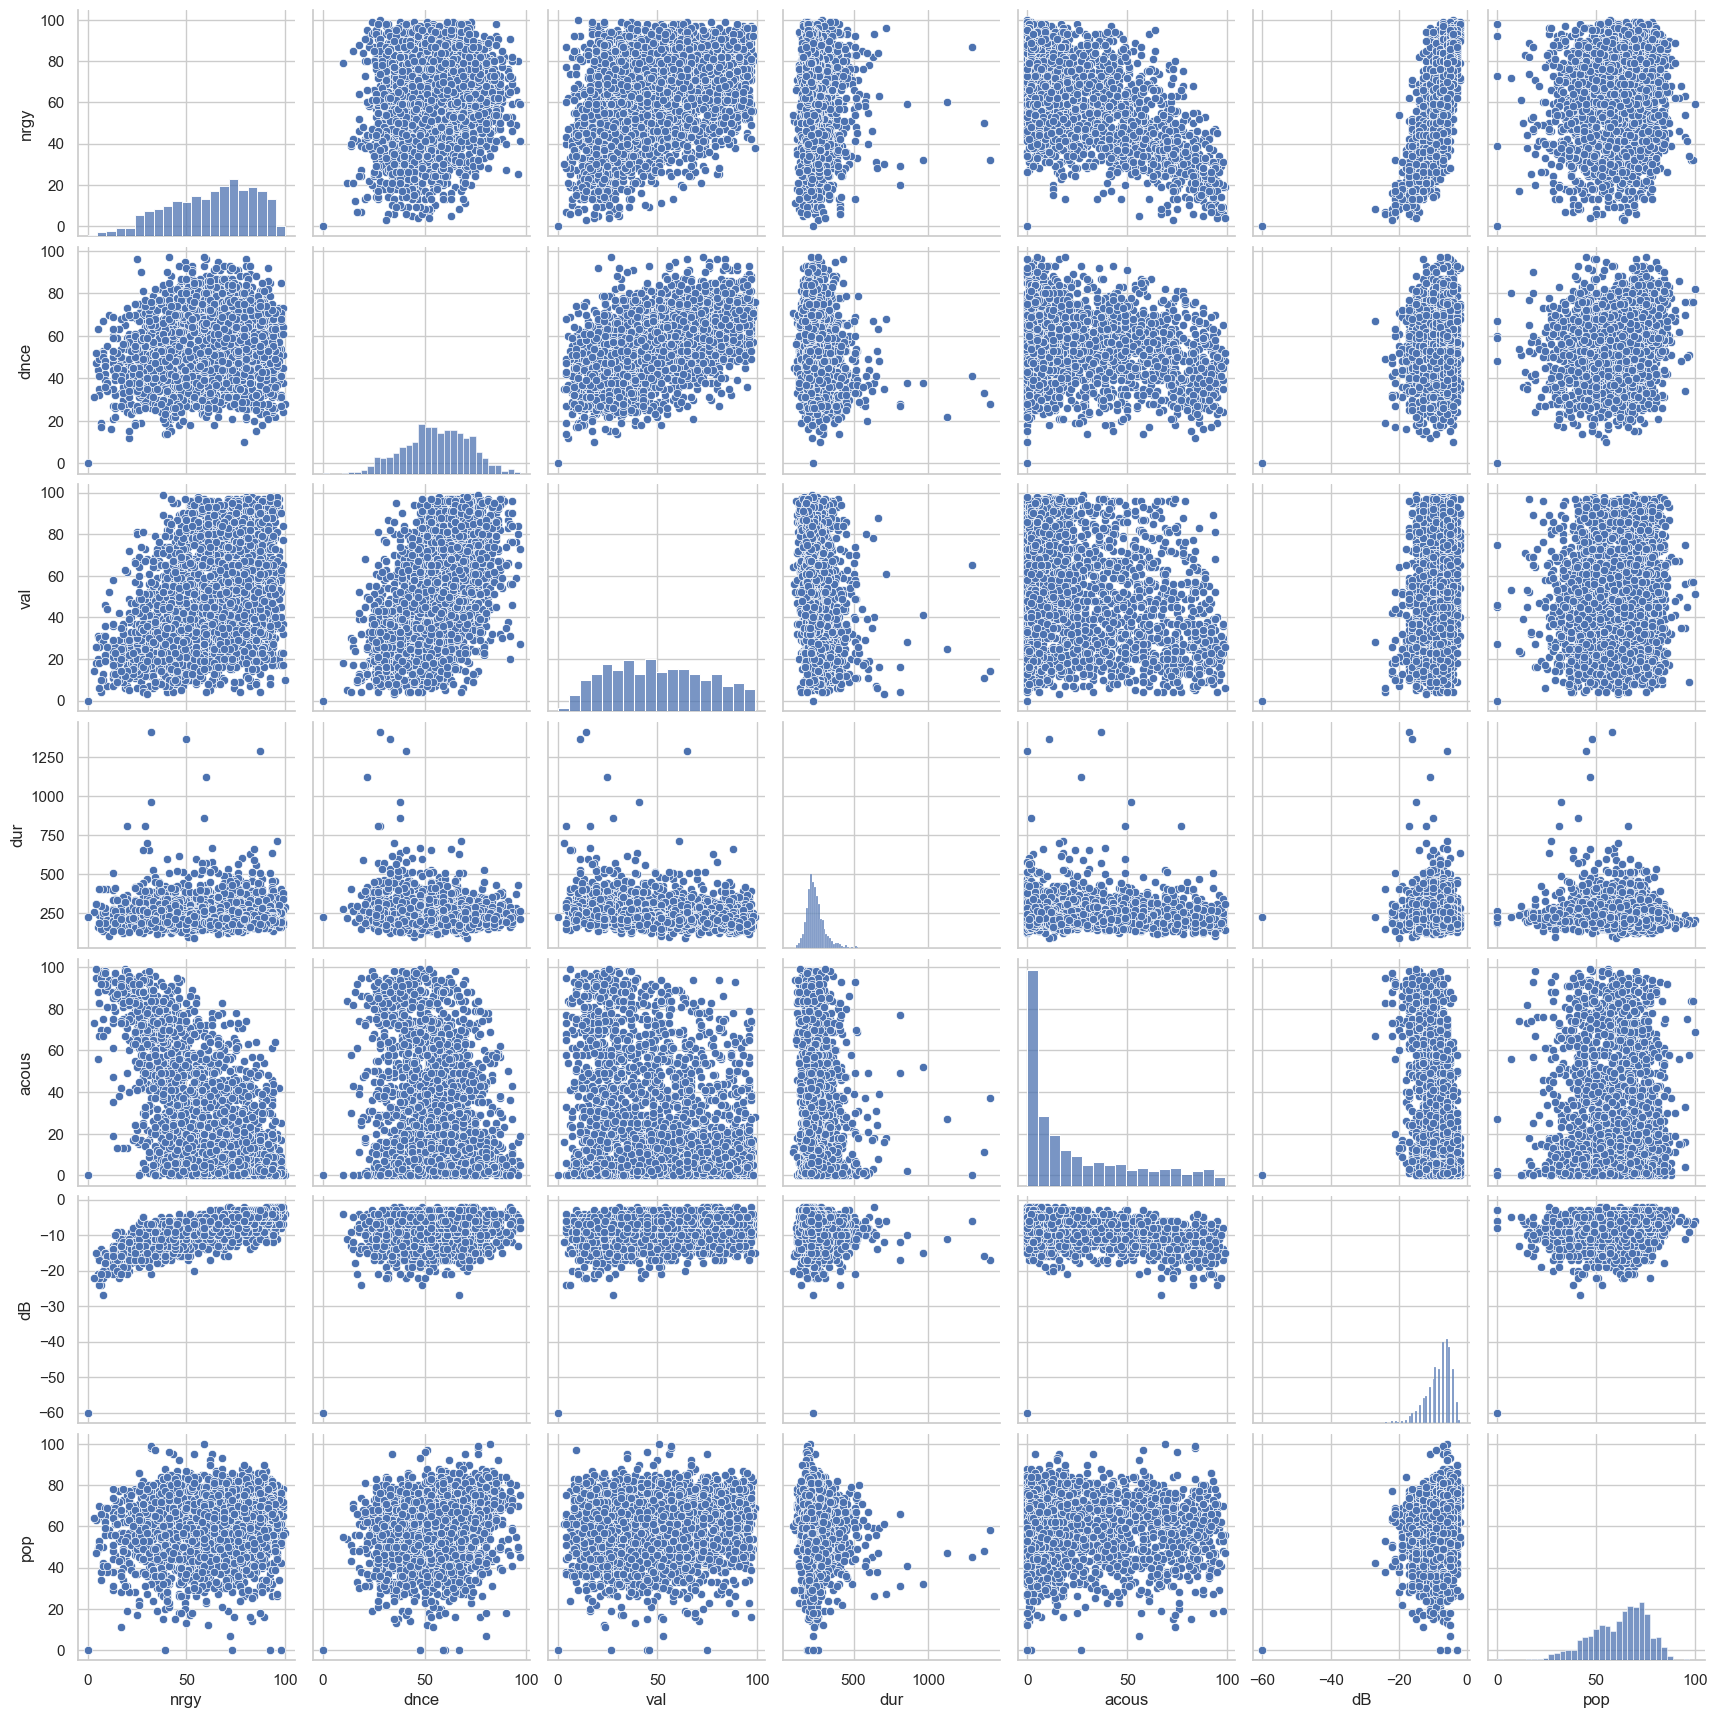

In [43]:
# Pairplot para relaciones principales
sns.pairplot(df_audiofeatures[['nrgy','dnce','val','dur','acous','dB','pop']])
plt.show()

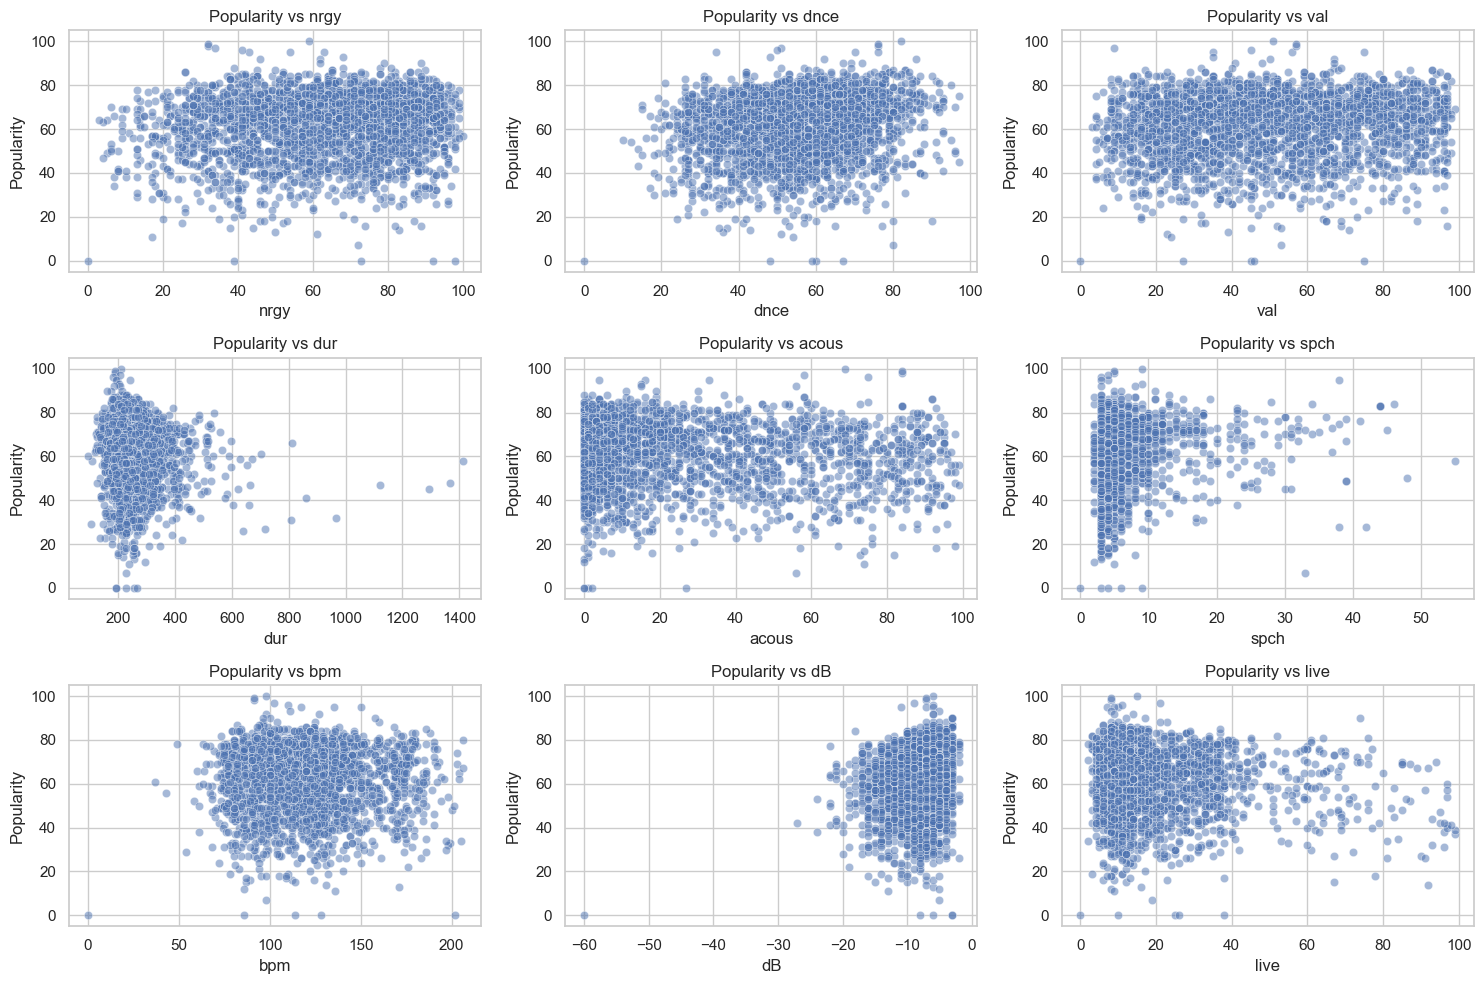

In [44]:
# Popularidad vs Features
plt.figure(figsize=(15,10))
features = ['nrgy','dnce','val','dur','acous','spch','bpm','dB','live']
for i, col in enumerate(features,1):
    plt.subplot(3,3,i)
    sns.scatterplot(data=df_audiofeatures, x=col, y='pop', alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Popularity')
    plt.title(f'Popularity vs {col}')
plt.tight_layout()
plt.show()

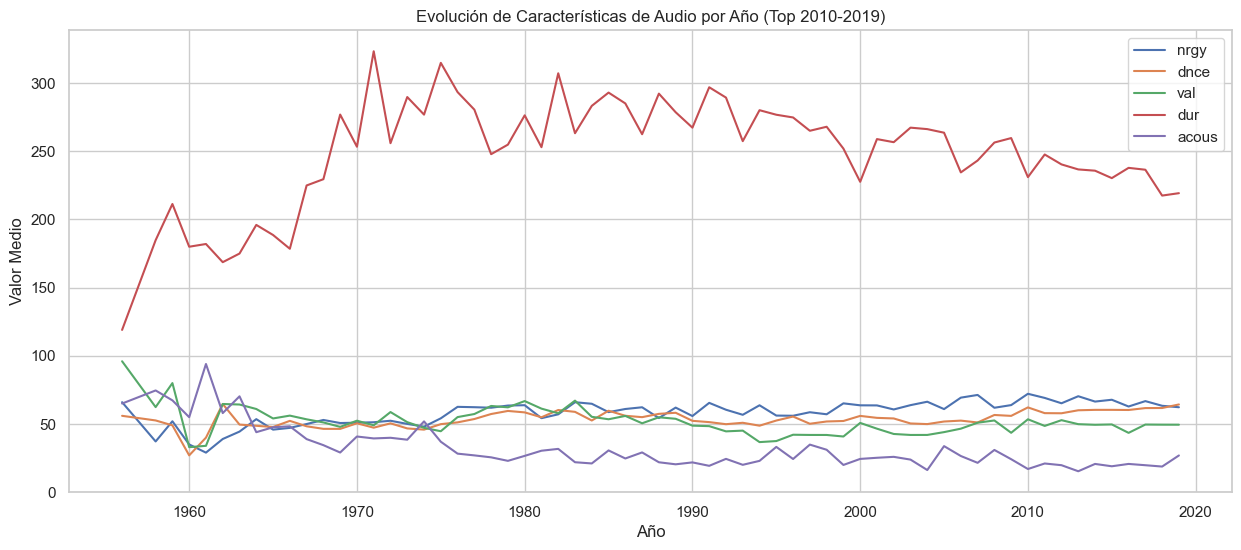

In [45]:
# Evolución media de features por año
avg_features_year = df_audiofeatures.groupby('year')[numeric_cols].mean().reset_index()
plt.figure(figsize=(15,6))
for col in ['nrgy','dnce','val','dur','acous']:
    sns.lineplot(data=avg_features_year, x='year', y=col, label=col)
plt.title('Evolución de Características de Audio por Año (Top 2010-2019)')
plt.xlabel('Año')
plt.ylabel('Valor Medio')
plt.legend()
plt.show()

## **5. Machine Learning**

This section implements **Machine Learning** models for two main objectives:
1.  **Similar Song Recommender (KNN):** Uses a **K-Nearest Neighbors** model on standardized and one-hot encoded audio features to find songs similar to a given track or artist, serving as the core of the recommender system.
2.  **Popularity Prediction (Random Forest):** Trains a **Random Forest Regressor** to predict a song's **Popularity** score based on its audio features and genre.
3.  **Explainability (SHAP):** Uses **SHAP values** to interpret the Popularity Prediction model, revealing which audio features have the greatest positive or negative impact on a song's predicted popularity.
4.  **Genre Prediction (Logistic Regression):** Implements a **Logistic Regression** classifier to predict a song's simplified **Genre** based on its audio features, providing a basic classification task.

In [46]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, linear_model, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import joblib

### 5.1. Similar Song Recommender

In [47]:
# seleccionar columnas
numeric_cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous','spch','pop']
categorical_cols = ['genre']
id_cols = ['title', 'artist']

In [48]:
# asegurar que las columnas numéricas son del tipo correcto
for col in numeric_cols:
    df_audiofeatures[col] = pd.to_numeric(df_audiofeatures[col], errors='coerce')
df_audiofeatures = df_audiofeatures.dropna(subset=numeric_cols)

In [49]:
# preparar preprocesador
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [50]:
# ajustar y transformar
X = preprocess.fit_transform(df_audiofeatures)

# guardar el preprocesador
joblib.dump(preprocess, 'models/recommender_preprocessor.pkl')

['models/recommender_preprocessor.pkl']

In [51]:
# entrenar el modelo de vecinos más cercanos (KNN)
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X)

joblib.dump(knn, "models/recommender_knn.pkl")

['models/recommender_knn.pkl']

In [52]:
# recomendacion por canción
def recommend_songs(song_title, df=df_audiofeatures, model=knn, transformer=preprocess, n=10):

    # buscamos la canción exacta
    match = df[df['title'].str.lower() == song_title.lower()]

    if match.empty:
        return f"No encontré la canción '{song_title}'."

    # vector transformado
    song_vector = transformer.transform(match)

    # vecinos más cercanos
    distances, indices = model.kneighbors(song_vector, n_neighbors=n+1)

    results = df.loc[indices[0][1:]]  # excluimos la misma canción
    results["similarity"] = 1 / (1 + distances[0][1:])  # opcional: convertir distancia en similitud

    return results[[*id_cols, "similarity"]]

# ejemplo de uso
recommend_songs("Shape of You")

,title,artist,similarity
2437,Shape of You,Ed Sheeran,1.000000
2506,There's Nothing Holdin' Me Back,Shawn Mendes,0.388088
2450,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,0.370382
2296,Sing,Ed Sheeran,0.352232
2438,Closer,The Chainsmokers,0.340830
2273,What Do You Mean?,Justin Bieber,0.335359
2512,Attention,Charlie Puth,0.331395
2581,I Don't Care (with Justin Bieber),Ed Sheeran,0.328723
2359,Cake By The Ocean,DNCE,0.324588
2571,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,0.321874


In [53]:
def recommend_songs_by_artist(artist_name, df=df_audiofeatures, model=knn, transformer=preprocess, n=10):

    # buscar canciones del artista
    artist_songs = df[df['artist'].str.lower() == artist_name.lower()]

    if artist_songs.empty:
        return f"No encontré canciones del artista '{artist_name}'."

    recommendations = []

    for _, song in artist_songs.iterrows():

        # convertir fila a DataFrame con 1 row
        song_df = song.to_frame().T  

        # vector transformado
        song_vector = transformer.transform(song_df)

        # vecinos
        distances, indices = model.kneighbors(song_vector, n_neighbors=n+1)

        # obtener canciones similares (excluimos la misma)
        recs = df.iloc[indices[0][1:]].copy()

        # añadir columna similitud
        recs["similarity"] = 1 / (1 + distances[0][1:])

        # guardar
        recommendations.append(recs[[*id_cols, "similarity"]])

    # concatenar todos los resultados
    recommendations = pd.concat(recommendations, ignore_index=True)

    # eliminar duplicados y ordenar
    recommendations = (
        recommendations
        .drop_duplicates(subset=id_cols)
        .sort_values("similarity", ascending=False)
        .head(n)
    )

    return recommendations

# ejemplo
recommend_songs_by_artist("Adele")

,title,artist,similarity
90,Hello,Adele,1.000000
40,Set Fire to the Rain,Adele,0.936244
91,When We Were Young,Adele,0.472858
31,All I Ask,Adele,0.469732
41,Rolling in the Deep,Adele,0.462379
42,Back To Black,Amy Winehouse,0.443655
201,Iron Sky,Paolo Nutini,0.428372
43,You Know I'm No Good,Amy Winehouse,0.406677
44,Rolling In The Deep,Adele,0.400652
45,Water Under the Bridge,Adele,0.398452


### 5.2. Popularity Prediction

We aimed to predict the popularity of Spotify tracks using available audio features and categorical information (genre and artist). Popularity reflects the listener’s reception, measured from 0 to 100. Our initial approach using only numeric features and regression yielded very low R² scores, motivating us to improve the model using feature engineering and classification.

In [81]:
# convert popularity to binary variable
df_audiofeatures['pop_bin'] = pd.qcut(df_audiofeatures['pop'], q=2, labels=[0,1])

In [88]:
X = df_audiofeatures.drop(columns=['pop_bin', 'pop', 'title', 'artist']) # independant / features
y = df_audiofeatures['pop_bin'] # dependant / target

X = pd.get_dummies(X, columns=['genre'], drop_first=True)

feature_names = X.columns
joblib.dump(feature_names, 'models/popularity_features.pkl')

# Split data into training and test sets: 80% training, 20% test split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print('Shape of Data:')
print('-')
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape,'y_test:', y_test.shape)


Shape of Data:
-
X_train: (2077, 88) y_train: (2077,)
X_test: (520, 88) y_test: (520,)


In [83]:

numeric_cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous','spch']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

In [84]:
logr_model = LogisticRegression(solver='liblinear')
dtree_model = tree.DecisionTreeClassifier()
nb_model = GaussianNB()

# Training the models

logr_model.fit(X_train, y_train)
dtree_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)

# Accuracy of trained models with training data:

logr_train_acc = logr_model.score(X_train, y_train)
dtree_train_acc = dtree_model.score(X_train, y_train)
nb_train_acc = nb_model.score(X_train, y_train)

print('Training Model Accuracy Outputs:')
print('-')
print(f"Logistic Regression: {round(logr_train_acc*100,2)} %")
print(f"Decision Tree: {round(dtree_train_acc*100,2)} %")
print(f"Naive Bayes: {round(nb_train_acc*100,2)} %")

Training Model Accuracy Outputs:
-
Logistic Regression: 67.12 %
Decision Tree: 99.9 %
Naive Bayes: 56.62 %


In [85]:

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=24)

accuracy_logr = cross_val_score(logr_model, X_train, y_train, scoring="accuracy", cv=kf).mean()
accuracy_dtree = cross_val_score(dtree_model, X_train, y_train, scoring="accuracy", cv=kf).mean()
accuracy_nb = cross_val_score(nb_model, X_train, y_train, scoring="accuracy", cv=kf).mean()

print('k-fold Cross Validation Accuracy Outputs:')
print('-')
print(f"Logistic Regression: {round(accuracy_logr*100,2)} %")
print(f"Decision Tree: {round(accuracy_dtree*100,2)} %")
print(f"Naive Bayes: {round(accuracy_nb*100,2)} %")

k-fold Cross Validation Accuracy Outputs:
-
Logistic Regression: 64.51 %
Decision Tree: 58.6 %
Naive Bayes: 55.17 %


In [86]:
# using the test data for our trained models:

print('Test data - Model Accuracy Outputs:')
print('-')
print(f"Logistic Regression: {round(logr_model.score(X_test, y_test)*100,2)} %")
print(f"Decision Tree: {round(dtree_model.score(X_test, y_test)*100,2)} %")
print(f"Naive Bayes: {round(nb_model.score(X_test, y_test)*100,2)} %")

Test data - Model Accuracy Outputs:
-
Logistic Regression: 64.04 %
Decision Tree: 59.62 %
Naive Bayes: 55.0 %


In [90]:
numeric_cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous','spch','year','year_block']
categorical_cols = [c for c in feature_names if c.startswith("genre_")]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', categorical_cols)  # already one-hot encoded
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='liblinear'))
])

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'models/popularity_pipeline.pkl')

['models/popularity_pipeline.pkl']

### 5.3. Explainability

In [91]:
import shap

In [92]:
shap.initjs()
explainer = shap.Explainer(logr_model, X_train)
shap_values = explainer(X_test)


In [93]:
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

Global Feature Importance:


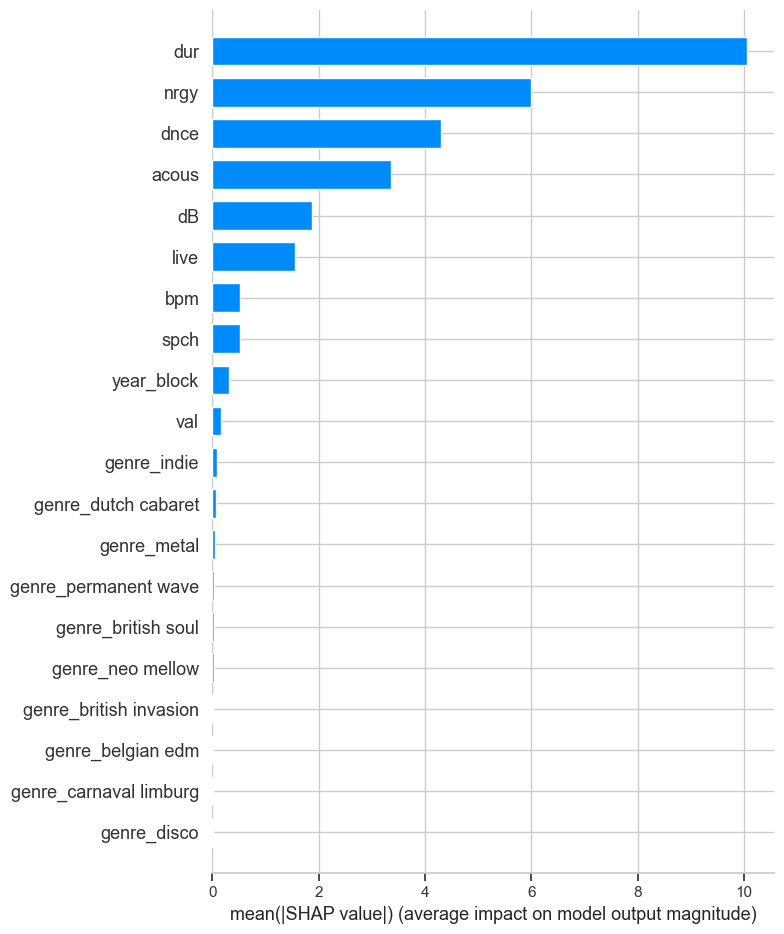

In [94]:
print("Global Feature Importance:")
shap.summary_plot(shap_values, X_test, plot_type="bar")

Local Explanation for Test Sample 0:


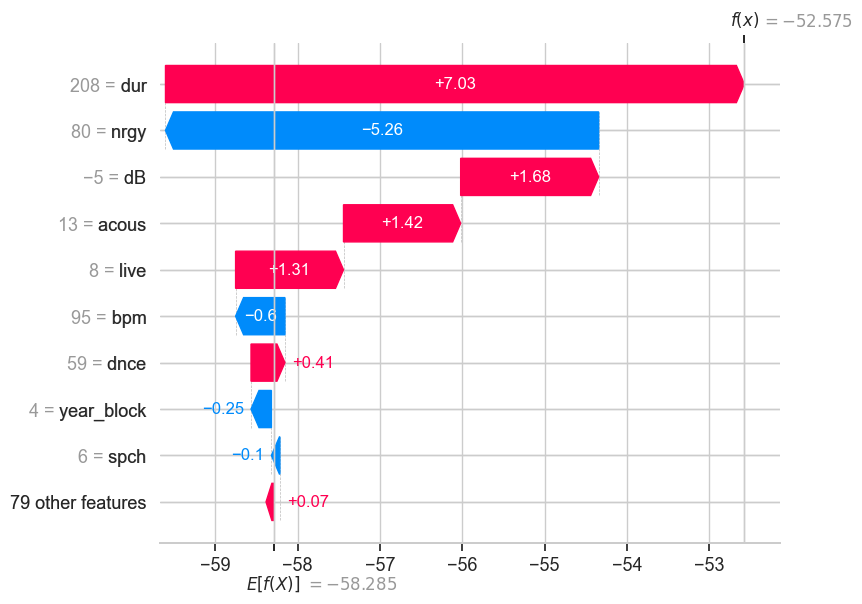

In [95]:
i = 0
print(f"Local Explanation for Test Sample {i}:")
shap.plots.waterfall(shap_values[i])

### 5.4. Genre Prediction

This section builds a machine-learning classifier that predicts a song’s genre based on its audio features. It requires genre simplification first:

In [66]:
feature_cols = ['bpm', 'dnce', 'live', 'val', 'dur', 'acous', 'spch', 
                'nrgy', 'dB']

X = df_audiofeatures[feature_cols]
y = df_audiofeatures['genre']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [67]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# save scaler
joblib.dump(scaler, "models/genre_scaler.pkl")

['models/genre_scaler.pkl']

In [68]:
model = LogisticRegression(multi_class="ovr", max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

pred_test = model.predict(X_test_scaled)

print("Test F1:", f1_score(y_test, pred_test, average="micro"))

# save model
joblib.dump(model, "models/genre_classifier.pkl")

/Users/macbook/Documents/GitHub/SpotifyAnalytics2025/env_va/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.



Test F1: 0.5


['models/genre_classifier.pkl']

In [69]:
# function to predict a song's genre
def predict_genre(song_title, df=df_audiofeatures, model=model, scaler=scaler):
    song_data = df[df['title'].str.lower() == song_title.lower()]
    if song_data.empty:
        return f"No encontré la canción '{song_title}'."
    song_features = song_data[feature_cols]
    song_features_scaled = scaler.transform(song_features)
    genre_pred = model.predict(song_features_scaled)
    true_genre = song_data['genre'].values[0]
    return {
        'Predicted Genre': genre_pred[0],
        'True Genre': true_genre
    }

# ejemplo de uso
print(predict_genre("Shape of You"))
print(predict_genre("Waitin' On A Sunny Day"))

{'Predicted Genre': 'pop', 'True Genre': 'pop'}
{'Predicted Genre': 'rock', 'True Genre': 'rock'}
